## Supervised CNN: Predicting Quantum Energies

##### **Goal:** We want to teach a Neural Network to look at a configuration of Spins (Up/Down) and the rules of the universe (J1 and J2 coupling constants) and predict the Ground State Energy.

##### **Why?** This establishes a baseline. If a simple CNN can't predict the energy when we *give* it the answer (Supervised), then the complex Unsupervised model (which has to guess the answer) certainly won't work.


### 1. Imports and Setup

In [2]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

def make_reproducible(seed=42):
    # 1. Python's built-in random (controls lists/loops)
    random.seed(seed)
    # 2. Numpy (controls data array creation)
    np.random.seed(seed)
    # 3. PyTorch CPU (controls weight initialization)
    torch.manual_seed(seed)
    # 4. PyTorch GPU (controls hardware randomness)
    torch.cuda.manual_seed_all(seed)
    # 5. Force GPU to be deterministic (no speed optimizations that change math)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random Seed set to {seed}. Results will be reproducible.")

make_reproducible(42)

# Check if we have a GPU (Graphics Card) available to speed this up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Hardware Check: Training will run on {device}")

Random Seed set to 42. Results will be reproducible.
Hardware Check: Training will run on cpu


### 2. The Dataset (Input Pipeline)
Input Tensor (3 Channels)
- To make the AI understand both the shape of the spins AND the physics parameters, we stack them:
- 1. **Channel 1:** The Spin Configuration (-1, +1, -1...)
- 2. **Channel 2:** The J1 Coupling Value (Repeated across the whole chain)
- 3. **Channel 3:** The J2 Coupling Value (Repeated across the whole chain)

Matrix of shape `(3, 14)` for every sample


In [3]:
class QuantumDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.spin_cols = [str(i) for i in range(14)]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        spins = row[self.spin_cols].values.astype(np.float32)
        J1 = float(row['J1'])
        J2 = float(row['J2'])
        
        # Stack inputs: Spins, J1 map, J2 map
        # Result shape: (3, 14)
        x = np.stack([
            spins, 
            np.full_like(spins, J1), 
            np.full_like(spins, J2)
        ], axis=0)
        
        y = float(row['Ground_State_Energy'])
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Load CSVs directly
print("\nLoading Data")
train_ds = QuantumDataset("train_set.csv")
val_ds   = QuantumDataset("val_set.csv")
test_ds  = QuantumDataset("test_set.csv")

# Create Batch Loaders
# shuffle=True for train is safe now because we set the seed above!
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)
print("Data Ready.")
print(f"Loaded {len(train_loader)} Training samples.")
print(f"Loaded {len(val_loader)} Validation samples.")
print(f"Loaded {len(test_loader)} Test samples.")


Loading Data
Data Ready.
Loaded 807 Training samples.
Loaded 173 Validation samples.
Loaded 173 Test samples.


Interpretation: 
Using batch loaders: Faster for model training
- Train set: Setting shuffle=true helps to ensure model does not memorize data by order
- Setting seed previously allows this results to be reproduceable

### 3. CNN Architecture

Using a 1D Convolutional Neural Network
- Convolution: Sliding window moving across chain of 14 spins, learning patterns
- Global Average Pooling: After learning local energy patterns, we average them
- Linear layers: Converts patterns into the Ground State Energy scalar output

In [4]:
class EnergyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 3 Channels (Spins, J1, J2) -> Output: 16 Features
        self.conv1 = nn.Conv1d(3, 16, kernel_size=3, padding=1)
        # Input: 16 Features -> Output: 32 Features
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        # Regression Head
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # Global Average (Squash spatial dimension 14 -> 1)
        x = x.mean(dim=-1) 
        # Prediction
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze()

model = EnergyCNN().to(device)
print("\nModel Architecture:")
print(model)


Model Architecture:
EnergyCNN(
  (conv1): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


Interpretation of architecture: 
1. Conv1: The Feature Detector
    - Input (3): The spins, the J1 and J2
    - Kernel size (3): 3 neighboring sites are seen each time, fitting the Hamiltonian's next-neighbour interactions
    - Output (16): Learns 16 different basic patterns
2. conv2: Pattern combiner
    - Input (16): The 16 patterns learnt previously
    - Output (32): Combines into 32 complex features to capture richer information about quantum state
3. Global Pooling average to obtain a single vector of size 32, representing average energy density 
4. fc1 & fc2: Linear layer to convert all the inputs into a single scalar number (Ground State Energy)

### 4. Training Loop
- MSE as valuation tool
- We use ADAM optimiser

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 20
train_history = []
val_history = []

print(f"{'Epoch':<5} | {'Train MSE':<12} | {'Val MSE':<12}")
print("-" * 35)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch | Train MSE    | Val MSE     
-----------------------------------


In [6]:
for epoch in range(1, epochs + 1):
    # Train
    model.train()
    batch_losses = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    
    train_loss = np.mean(batch_losses)
    train_history.append(train_loss)

    # Validation
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_batch_losses.append(loss_fn(pred, y).item())
            
    val_loss = np.mean(val_batch_losses)
    val_history.append(val_loss)
    
    #Print progress
    if epoch == 1 or epoch % 5 == 0 or epoch == epochs:
        print(f"{epoch:<5} | {train_loss:.6f}     | {val_loss:.6f}")

1     | 4.627272     | 1.216351
5     | 0.038482     | 0.031997
10    | 0.017982     | 0.020390
15    | 0.014936     | 0.012320
20    | 0.014418     | 0.015013


Minimum Validation Loss: 0.012


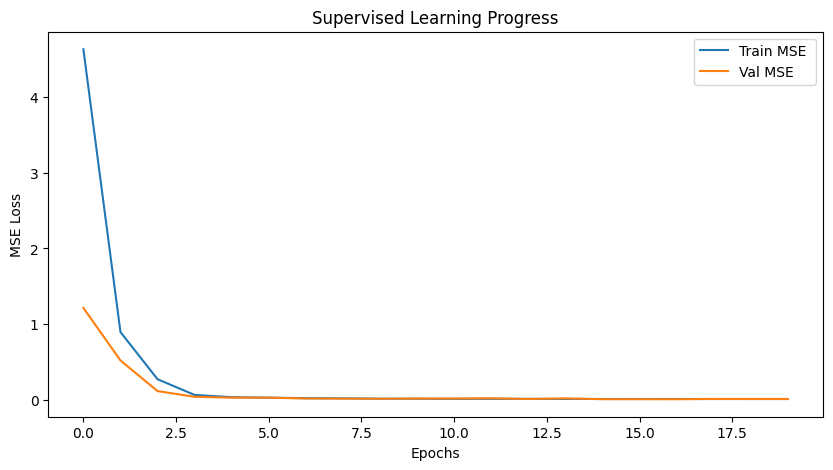

In [7]:
min_val_loss = min(val_history)
print("Minimum Validation Loss:", round(min_val_loss,3))

# Plotting the Learning Curve
plt.figure(figsize=(10,5))
plt.plot(train_history, label="Train MSE ")
plt.plot(val_history, label="Val MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Supervised Learning Progress")
plt.show()

Interpretation:
- Elbow occurs at around first 3-5 epochs, showing that the model learns the main physics rules and loss drops dramatically
- Stability occurs after epoch 5 and there is no overfitting as the orange line (validation) does not increase
- Minimum Val Loss is 0.011 which means the model has learnt well, given that typical Ground State Energies in EDA Analysis of generated dataset is around -3.0 to -14.0
- Relative error of less than $1\%$, meaning that CNN is able to capture the physics with high precision


### 5. Test set evaluation
We use MAE to see how far our energy prediction is off by


FINAL TEST RESULTS (Held-out Data)
Mean Absolute Error (MAE): 0.0895
Mean Squared Error  (MSE): 0.0147
Root Mean Squared Error  (RMSE): 0.1211


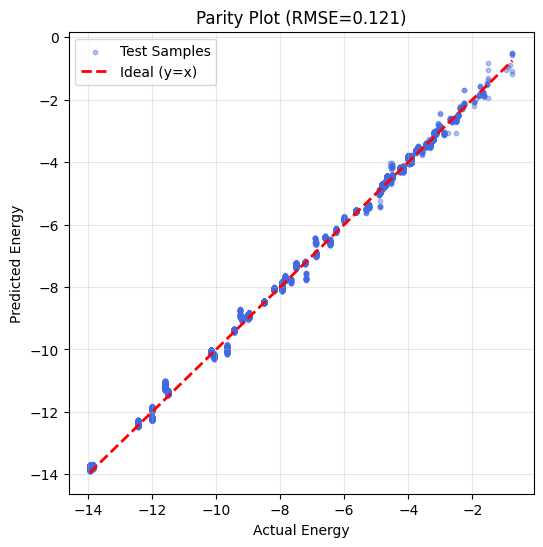

In [8]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

mae = np.mean(np.abs(np.array(all_preds) - np.array(all_targets)))
mse = np.mean((np.array(all_preds) - np.array(all_targets))**2)
rmse = np.sqrt(mse)
print("\n" + "="*40)
print("FINAL TEST RESULTS (Held-out Data)")
print("="*40)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error  (MSE): {mse:.4f}")
print(f"Root Mean Squared Error  (RMSE): {rmse:.4f}")
print("="*40)

# Parity Plot
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.4, s=10, c='royalblue', label='Test Samples')
min_val, max_val = min(all_targets), max(all_targets)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal (y=x)')
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title(f'Parity Plot (RMSE={rmse:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Interpretation: 

Baseline error: Standard deviation of training dataset, 3.42 (referenced from EDA analysis)

CNN model error: RMSE=0.1399

CNN model is roughly 3.42/0.1399 = 24.4 times more accurate than baseline error. It captures 99.8% of variance in dataset.

Relative Accuracy: 
Dataset mean energy = -7.64
MAE = 0.1180
Relative error = 0.1180/7.64 = 1.5%

Model is precise to within 1.5% of the exact diagonalization results, hence it is quite accurate.


